# 中央値の信頼区間2

Part 1: [中央値の信頼区間](https://github.com/genkuroki/public/blob/main/0028/confidence%20interval%20of%20median.ipynb)
$
\newcommand\R{\Bbb{R}}
\newcommand\Beta{\operatorname{Beta}}
\newcommand\Binomial{\operatorname{Binomial}}
\newcommand\dist{\operatorname{dist}}
\newcommand\empirical{\operatorname{empirical}}
\newcommand\pval{\operatorname{pval}}
\newcommand\median{\operatorname{median}}
\newcommand\ci{\operatorname{ci}}
\newcommand\pdf{\operatorname{pdf}}
\newcommand\cdf{\operatorname{cdf}}
\newcommand\ecdf{\operatorname{ecdf}}
\newcommand\quantile{\operatorname{quantile}}
\newcommand\on{\operatorname}
$

In [1]:
using Distributions
using StatsPlots
default(titlefontsize=10, fmt=:png)
using Random
using StatsBase
using QuadGK
using StaticArrays

name(dist::UnivariateDistribution) = replace(string(dist), r"{[^{.]*}"=>"")

function pdf_median_true(n, z)
    0 < z < 1 || return 0.0
    m = n / 2
    p(x, y) = pdf(Dirichlet(SVector(m, 1, m)), SVector(x, y-x, 1-y))
    2quadgk(x -> p(x, 2z - x), 0, z)[1]
end

function plot_mediandists(n; kwargs...)
    plot(x -> pdf_median_true(n, x), 0, 1; label="true dist")
    plot!(x -> pdf(Beta((n+1)/2, (n+1)/2), x), 0, 1; ls=:dash, label="n")
    plot!(x -> pdf(Beta((n+2)/2, (n+2)/2), x), 0, 1; ls=:dashdot, label="n'=n+1")
    title!("dist of median and approx: n = $n")
    plot!(; kwargs...)
end

function plot_mediandist_approx()
    PP = []
    P = plot_mediandists(2; legend=:bottom)
    push!(PP, P)
    for n in 4:2:12
    P = plot_mediandists(n; legend=false)
        push!(PP, P)
    end
    plot(PP...; size=(900, 540), layout=(2, 3))
end

plot_mediandist_approx (generic function with 1 method)

## ブートストラップ法

$n$ が奇数のとき, 一様分布 $\on{Uniform}(0, 1)$ のサイズ $n$ の標本の中央値の真の分布は $\Beta((n+1)/2, (n+1)/2)$ になる([順序統計量 - Wikipedia](https://ja.wikipedia.org/wiki/%E9%A0%86%E5%BA%8F%E7%B5%B1%E8%A8%88%E9%87%8F) を参照せよ).

$n$ が10以上の偶数の場合には, 一様分布 $\on{Uniform}(0, 1)$ のサイズ $n$ の標本の中央値の真の分布の良い近似として, $n' = n+1$ とおいて, $\Beta((n'+1)/2, (n'+1)/2)$ を採用できる. 以下のセルを見よ.

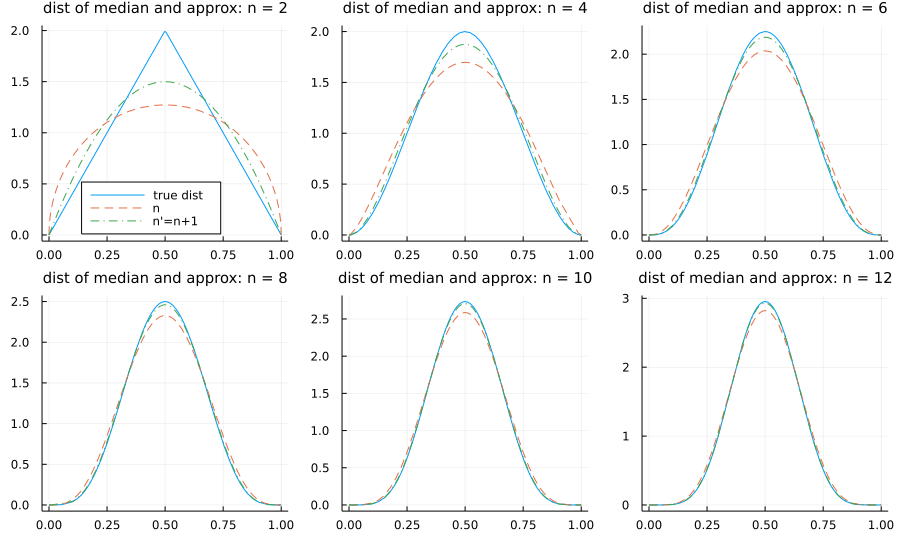

In [2]:
plot_mediandist_approx()

$n$ が奇数のときは $n'=n$ とおき, $n$ が偶数のときには $n'=n+1$ とおいて, 標本サイズ $n$ に対して, 

$$
\on{beta}=\Beta((n'+1)/2, (n'+1)/2)
$$

と定める(左右対称なベータ分布). このとき, 信頼係数 $1-\alpha$ の中央値の信頼区間 $[L, U]$ を次のように構成できる(ブートストラップ法):

$$
\begin{aligned}
&
L = \quantile(X, \quantile(\on{beta}, \alpha/2)),
\\ &
U = \quantile(X, \quantile(\on{beta}, 1-\alpha/2)).
\end{aligned}
$$

対応するP値函数は次のように書ける:

$$
\pval_{\on{bootstrap}}(X, a) = \min\left(
\begin{array}{l}
1 \\
2\cdf(\on{beta}, \ecdf(X)(a)) \\
2(1 - \cdf(\on{beta}, \ecdf(X)(a))) \\
\end{array}
\right).
$$

信頼区間とP値の概念は表裏一体である(竹内啓『数理統計学』 p.103, 竹村彰通『現代数理統計学』 p.202, 久保川達也『現代数理統計学の基礎』 p.169).
P値函数と信頼区間の対応は, 与えられたデータについて, P値函数の値がα以上になるパラメータの範囲が信頼区間に一致するという条件で与えられる.

データが与えられたとき, 横軸をパラメータとするP値函数のグラフを描いたとき, 
そのグラフを高さ $\alpha$ で切断して得られる区間が信頼係数 $1-\alpha$ の信頼区間になる.

異なる方法で構成された信頼区間を比較するには, 対応するP値函数を比較すればよい.

In [3]:
function beta_median(n)
    n += iseven(n)
    Beta((n+1)/2, (n+1)/2)
end

function ci_median_bootstrap(X::AbstractVector; α = 0.05)
    beta = beta_median(length(X))
    L = quantile(X, quantile(beta, α/2))
    U = quantile(X, quantile(beta, 1 - α/2))
    L, U
end

function cdf_median_bootstrap(X::AbstractVector, a)
    beta = beta_median(length(X))
    cdf(beta, ecdf(X)(a))
end

function pval_median_bootstrap(X, a)
    c = cdf_median_bootstrap(X, a)
    min(1, 2c, 2(1 - c))
end

pval_median_bootstrap (generic function with 1 method)

[L, U] = [4.373775826777367, 7.135798655673584]


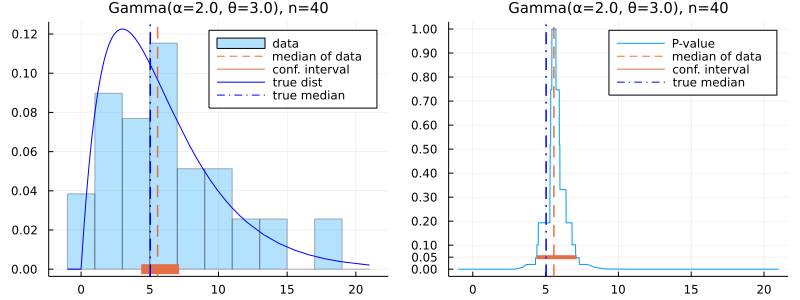

In [4]:
Random.seed!(3734649)

# テストサンプルの生成
dist = Gamma(2, 3)
n = 40
X = rand(dist, n)

# 信頼区間の計算
L, U = ci_median_bootstrap(X; α = 0.05)
@show [L, U]

# プロット
P1 = histogram(X; norm=true, alpha=0.3, bin=-1:2:21, label="data")
vline!([median(X)]; label="median of data", lw=1.5, c=2, ls=:dash)
plot!([L, U], zeros(2); label="conf. interval", lw=10, c=2)
plot!(dist, -1, 21; label="true dist", c=:blue)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")

P2 = plot(x -> pval_median_bootstrap(X, x), -1, 21; label="P-value")
vline!([median(X)]; label="median of data", lw=1.5, c=2, ls=:dash)
plot!([L, U], fill(0.05, 2); label="conf. interval", lw=4, c=2)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")
plot!(; ytick=[0:0.05:0.1; 0.2:0.1:1])

plot(P1, P2; size=(800, 300))

## 二項分布に帰着

標本 $X=(X_1,\ldots,X_n)$ を小さな順に並べたもの(sortしたもの)を $X(1)\le\cdots\le X(n)$ と書く.

$\on{bin} = \Binomial(n, 1/2)$ (試行回数 $n$ の二項分布)とおく.

信頼係数 $1-\alpha$ の中央値の信頼区間 $[L, U]$ を次のようにも構成できる:

$$
\begin{aligned}
&
L = X(\quantile(\on{bin}, \alpha/2)),
\\ &
U = X(\quantile(\on{bin}, 1 - \alpha/2)).
\end{aligned}
$$

対応するP値函数は次のように書ける:

$$
\pval_{\on{binomial}}(X, a) = \min\left(
\begin{array}{l}
1 \\
2\cdf(\on{bin}, k) \\
2(1 - \cdf(\on{bin}, k')) \\
\end{array}
\right).
$$

ここで $k$ は $a$ 以下の $X_i$ の個数であり, $k'$ は $a$ 未満の $X_i$ の個数である.

信頼区間とP値の概念は表裏一体である(竹内啓『数理統計学』 p.103, 竹村彰通『現代数理統計学』 p.202, 久保川達也『現代数理統計学の基礎』 p.169).
P値函数と信頼区間の対応は, 与えられたデータについて, P値函数の値がα以上になるパラメータの範囲が信頼区間に一致するという条件で与えられる.

データが与えられたとき, 横軸をパラメータとするP値函数のグラフを描いたとき, 
そのグラフを高さ $\alpha$ で切断して得られる区間が信頼係数 $1-\alpha$ の信頼区間になる.

異なる方法で構成された信頼区間を比較するには, 対応するP値函数を比較すればよい.

In [5]:
bin_median(n) = Binomial(n, 1/2)

function ci_median_binomial(X::AbstractVector; α = 0.05)
    bin = bin_median(length(X))
    Xord = sort(X)
    L = Xord[quantile(bin, α/2)]
    U = Xord[quantile(bin, 1 - α/2)]
    L, U
end

function pval_median_binomial(X::AbstractVector, a)
    bin = bin_median(length(X))
    k  = count(≤(a), X)
    k′ = count(<(a), X)
    min(1, 2cdf(bin, k), 2ccdf(bin, k′))
end

pval_median_binomial (generic function with 1 method)

ci_bst = ci_median_bootstrap(X; α = 0.05) = (4.373775826777367, 7.135798655673584)
ci_bin = ci_median_binomial(X; α = 0.05) = (4.31001037009797, 7.063926114907236)


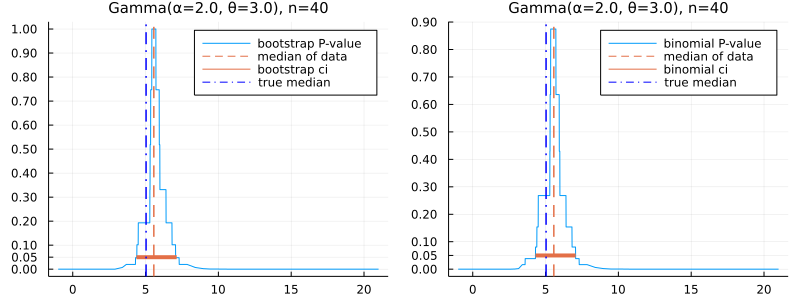

In [6]:
Random.seed!(3734649)

# テストサンプルの生成
dist = Gamma(2, 3)
n = 40
X = rand(dist, n)

# 信頼区間の計算
@show ci_bst = ci_median_bootstrap(X; α = 0.05)
@show ci_bin = ci_median_binomial(X; α = 0.05)

# プロット
P2 = plot(x -> pval_median_bootstrap(X, x), -1, 21; label="bootstrap P-value")
vline!([median(X)]; label="median of data", lw=1.5, c=2, ls=:dash)
plot!(collect(ci_bst), fill(0.05, 2); label="bootstrap ci", lw=4, c=2)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")
plot!(; ytick=[0:0.05:0.1; 0.2:0.1:1])

P3 = plot(x -> pval_median_binomial(X, x), -1, 21; label="binomial P-value")
vline!([median(X)]; label="median of data", lw=1.5, c=2, ls=:dash)
plot!(collect(ci_bin), fill(0.05, 2); label="binomial ci", lw=4, c=2)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")
plot!(; ytick=[0:0.05:0.1; 0.2:0.1:1])

plot(P2, P3; size=(800, 300))

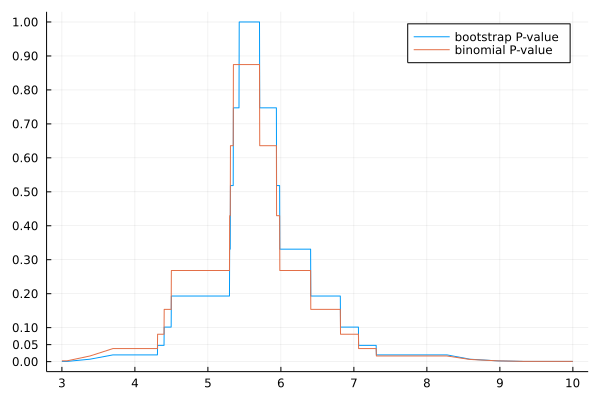

In [7]:
plot(x -> pval_median_bootstrap(X, x), 3, 10; label="bootstrap P-value")
plot!(x -> pval_median_binomial(X, x), 3, 10; label="binomial P-value")
plot!(; xtick=-1:21, ytick=[0:0.05:0.1; 0.2:0.1:1])

## 二項分布とベータ分布の関係

二項分布 $\Beta(n, p)$ における累積分布函数はベータ分布の累積分布函数で記述できる:

$$
\begin{aligned}
&
\sum_{j=0}^k \binom{n}{j} p^j(1-p)^{n-j} = \int_p^1 \frac{t^k(1-k)^{n-k-1}}{B(k+1, n-k)}\,dt,
\\ &
\sum_{j=k}^n \binom{n}{j} p^j(1-p)^{n-j} = \int_0^p \frac{t^{k-1}(1-k)^{n-k}}{B(k, n-k+1)}\,dt.
\end{aligned}
$$

すなわち,

$$
\begin{aligned}
&
\cdf(\Binomial(n, p), k) = 1 - \cdf(\Beta(k+1, n-k), p), 
\\ &
1 - \cdf(\Binomial(n, p), k-1) = \cdf(\Beta(k, n-k+1), p).
\end{aligned}
$$

以下のセルに数値的な確認がある. 証明は両辺を $p$ で微分しても得られるし, 右辺の積分で部分積分を繰り返しても得られる.

この関係を使うと, 二項分布による記述をベータ分布による記述に書き換えたり, パラメータが整数のベータ分布による記述を二項分布による記述に書き換えたりできる. 以上の中央値の区間推定や検定の記述はこの書き換えによって見かけ上異なる記述が得られる. 例えば, 

* 奥村晴彦, [ヒストグラムから中央値・分位数とその信頼区間を求める](https://oku.edu.mie-u.ac.jp/~okumura/python/hist-median.html)

に書いてある中央値の区間推定と検定の式を見るときには注意が必要である.

[cdf(Binomial(n, p), k) for k = 0:n - 1] .== [ccdf(Beta(k + 1, n - k), p) for k = 0:n - 1] = Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[ccdf(Binomial(n, p), k - 1) for k = 1:n] .== [cdf(Beta(k, (n - k) + 1), p) for k = 1:n] = Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


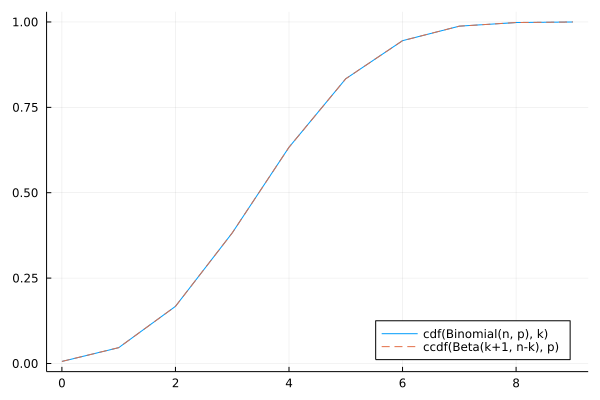

In [8]:
n, p = 10, 0.4
@show [cdf(Binomial(n, p), k) for k in 0:n-1] .== [ccdf(Beta(k+1, n-k), p) for k in 0:n-1]
@show [ccdf(Binomial(n, p), k-1) for k in 1:n] .== [cdf(Beta(k, n-k+1), p) for k in 1:n]

plot(; legend=:bottomright)
plot!(0:n-1, [cdf(Binomial(n, p), k) for k in 0:n-1]; label="cdf(Binomial(n, p), k)")
plot!(0:n-1, [ccdf(Beta(k+1, n-k), p) for k in 0:n-1]; label="ccdf(Beta(k+1, n-k), p)", ls=:dash)

## 第一種の過誤の確率の比較

In [9]:
function sim_pval_median(; dist = Gamma(2, 3), n = 40, L = 10^5)
    a = median(dist)
    pval_bst = Vector{Float64}(undef, L)
    pval_bin = Vector{Float64}(undef, L)
    tmp = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        X = rand!(dist, tmp[Threads.threadid()])
        pval_bst[i] = pval_median_bootstrap(X, a)
        pval_bin[i] = pval_median_binomial(X, a)
    end
    pval_bst, pval_bin
end

function plot_probtype1error(; dist = Gamma(2, 3), n = 40, L = 10^5)
    pval_bst, pval_bin = sim_pval_median(; dist, n, L)
    ecdf_bst = ecdf(pval_bst)
    ecdf_bin = ecdf(pval_bin)
    
    α = range(0, 1, 401)
    P1 = plot(; legend=:bottomright)
    plot!(α, α -> ecdf_bst(α); label="bootstrap")
    plot!(α, α -> ecdf_bin(α); label="binomial", ls=:dash)
    plot!([0, 1], [0, 1]; label="", ls=:dot, c=:black)
    plot!(; xtick=0:0.1:1, ytick=0:0.1:1)
    title!("$(name(dist)), n=$n")
    plot!(; xlabel="nominal significance level α", ylabel = "probability of type I error")

    α = range(0, 0.1, 401)
    P2 = plot(; legend=:bottomright)
    plot!(α, α -> ecdf_bst(α); label="bootstrap")
    plot!(α, α -> ecdf_bin(α); label="binomial", ls=:dash)
    plot!([0, 0.1], [0, 0.1]; label="", ls=:dot, c=:black)
    plot!(; xtick=0:0.01:1, ytick=0:0.01:1)
    title!("$(name(dist)), n=$n")
    plot!(; xlabel="nominal significance level α", ylabel = "probability of type I error")
    
    plot(P1, P2; size=(800, 400), leftmargin=3Plots.mm, bottommargin=3Plots.mm)
end

plot_probtype1error (generic function with 1 method)

第一種の過誤の確率は母集団分布によらない.

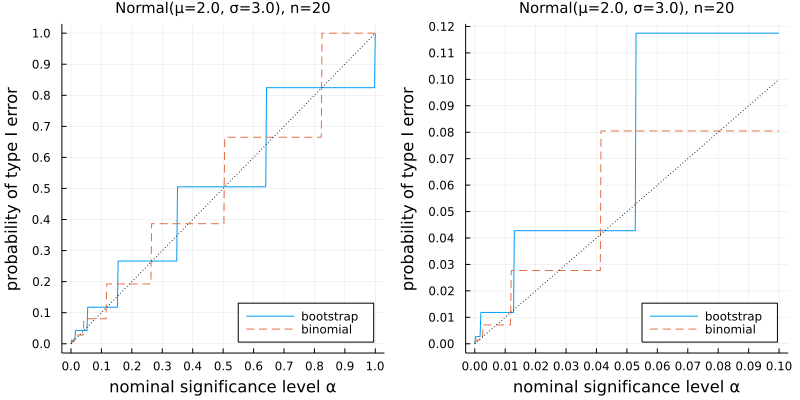

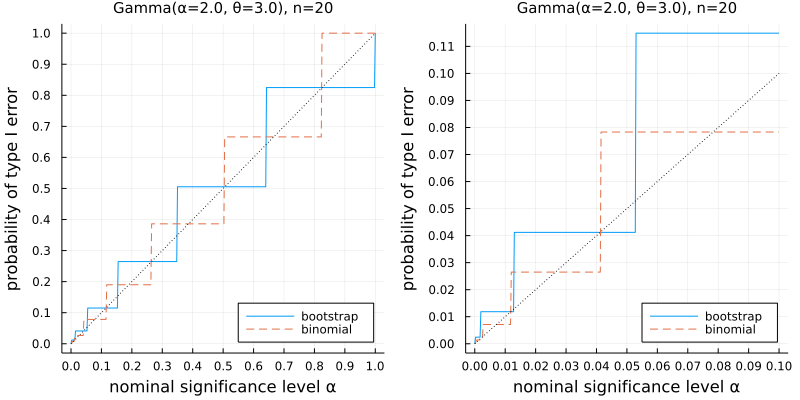

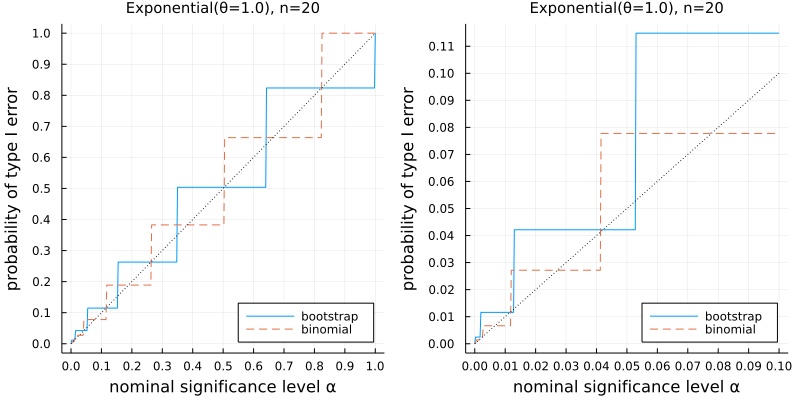

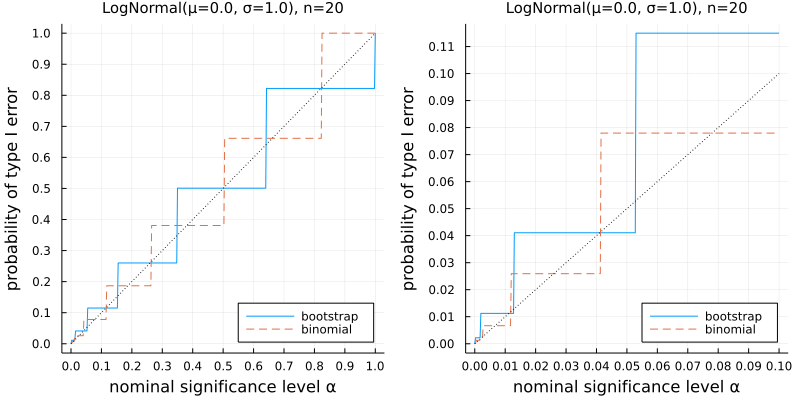

In [10]:
for dist in (Normal(2, 3), Gamma(2, 3), Exponential(), LogNormal())
    plot_probtype1error(; dist, n = 20) |> display
    println(); flush(stdout)
end

第一種の過誤の確率は名目有意水準に近い方がよい. この点に関して2つの方法の優劣は付け難い.

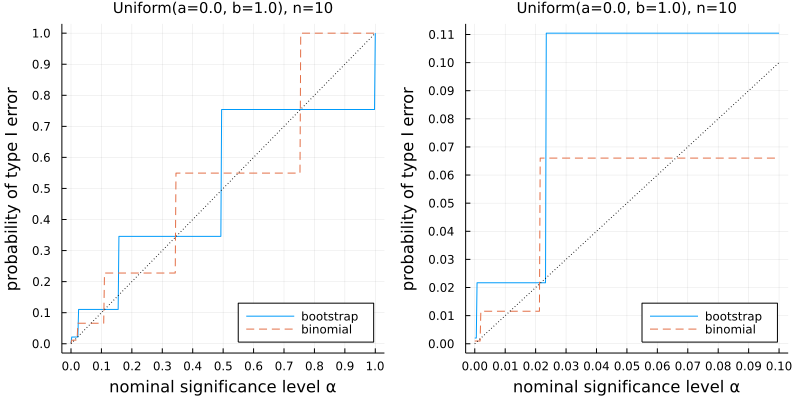

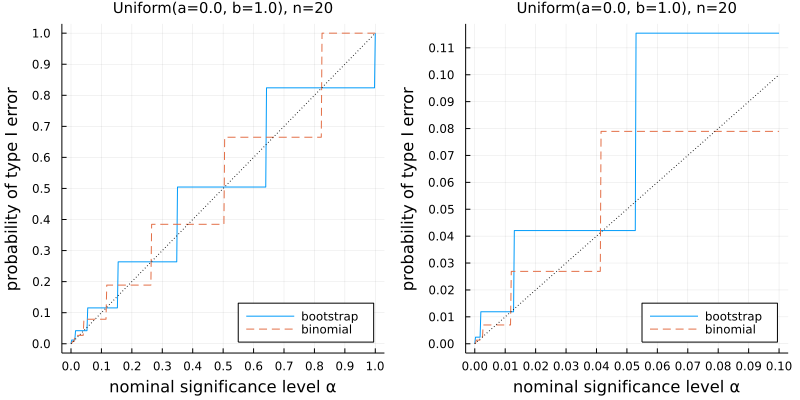

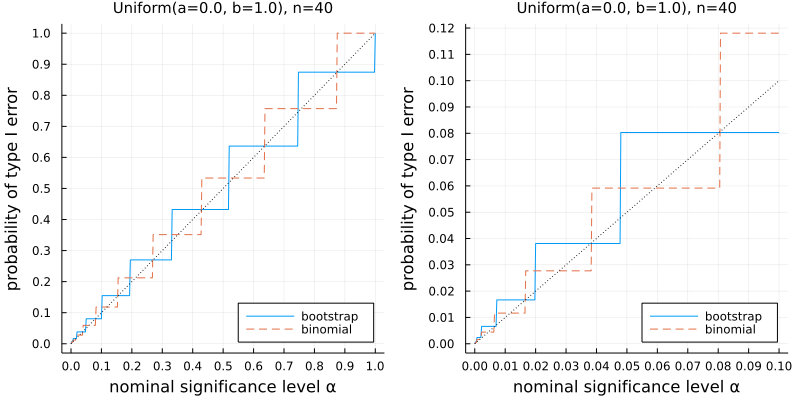

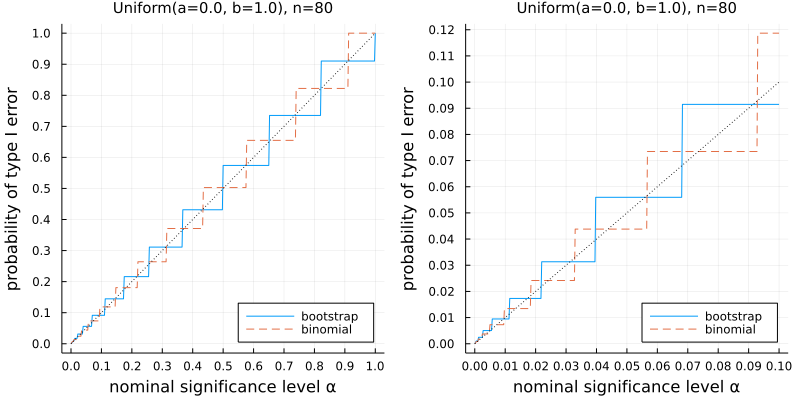

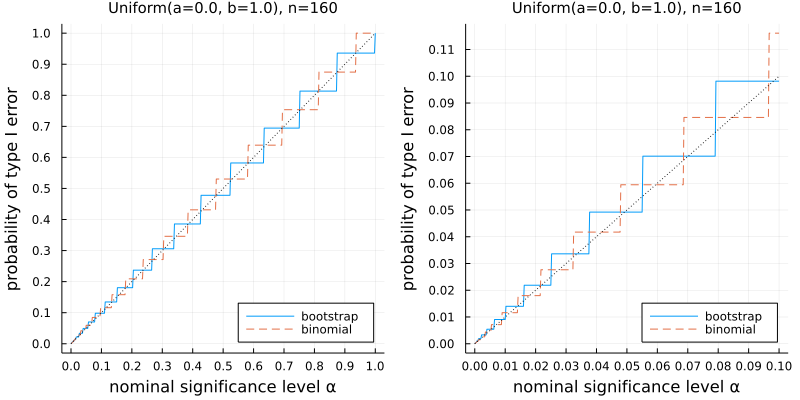

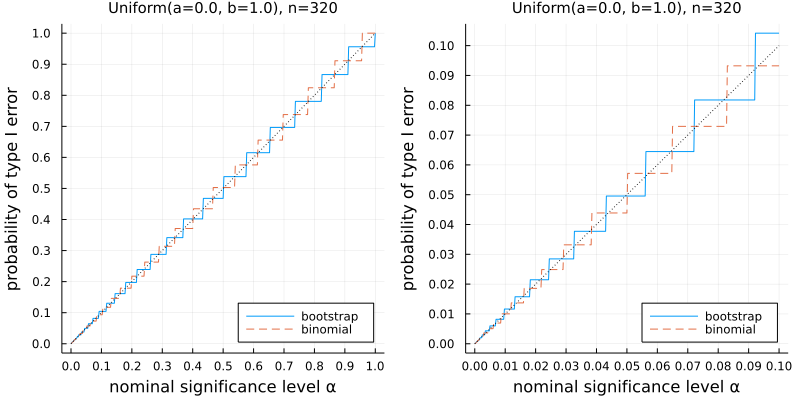

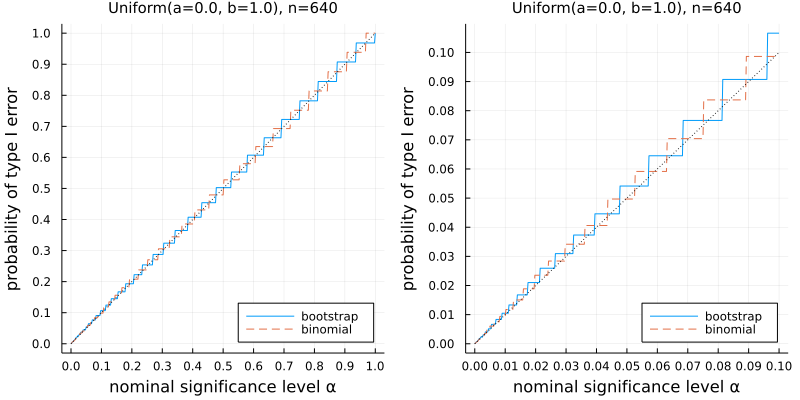

In [11]:
dist = Uniform()
for n in (10, 20, 40, 80, 160, 320, 640)
    plot_probtype1error(; dist, n) |> display
    println(); flush(stdout)
end

## 2つのP値の平均

In [12]:
pval_median_averaged(X, a) = (pval_median_bootstrap(X, a) + pval_median_binomial(X, a)) / 2

function sim_pval_median3(; dist = Gamma(2, 3), n = 40, L = 10^5)
    a = median(dist)
    pval_bst = Vector{Float64}(undef, L)
    pval_bin = Vector{Float64}(undef, L)
    pval_ave = Vector{Float64}(undef, L)
    tmp = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        X = rand!(dist, tmp[Threads.threadid()])
        pval_bst[i] = pval_median_bootstrap(X, a)
        pval_bin[i] = pval_median_binomial(X, a)
        pval_ave[i] = (pval_bst[i] + pval_bin[i])/2
    end
    pval_bst, pval_bin, pval_ave
end

function plot_probtype1error3(; dist = Gamma(2, 3), n = 40, L = 10^5)
    pval_bst, pval_bin, pval_ave = sim_pval_median3(; dist, n, L)
    ecdf_bst = ecdf(pval_bst)
    ecdf_bin = ecdf(pval_bin)
    ecdf_ave = ecdf(pval_ave)
    
    α = range(0, 1, 401)
    P1 = plot(; legend=:bottomright)
    plot!(α, α -> ecdf_bst(α); label="bootstrap")
    plot!(α, α -> ecdf_bin(α); label="binomial", ls=:dash)
    plot!(α, α -> ecdf_ave(α); label="average", ls=:dot, lw=2)
    plot!([0, 1], [0, 1]; label="", ls=:dot, c=:black)
    plot!(; xtick=0:0.1:1, ytick=0:0.1:1)
    title!("$(name(dist)), n=$n")
    plot!(; xlabel="nominal significance level α", ylabel = "probability of type I error")

    α = range(0, 0.1, 401)
    P2 = plot(; legend=:bottomright)
    plot!(α, α -> ecdf_bst(α); label="bootstrap")
    plot!(α, α -> ecdf_bin(α); label="binomial", ls=:dash)
    plot!(α, α -> ecdf_ave(α); label="average", ls=:dot, lw=2)
    plot!([0, 0.1], [0, 0.1]; label="", ls=:dot, c=:black)
    plot!(; xtick=0:0.01:1, ytick=0:0.01:1)
    title!("$(name(dist)), n=$n")
    plot!(; xlabel="nominal significance level α", ylabel = "probability of type I error")
    
    plot(P1, P2; size=(800, 400), leftmargin=3Plots.mm, bottommargin=3Plots.mm)
end

plot_probtype1error3 (generic function with 1 method)

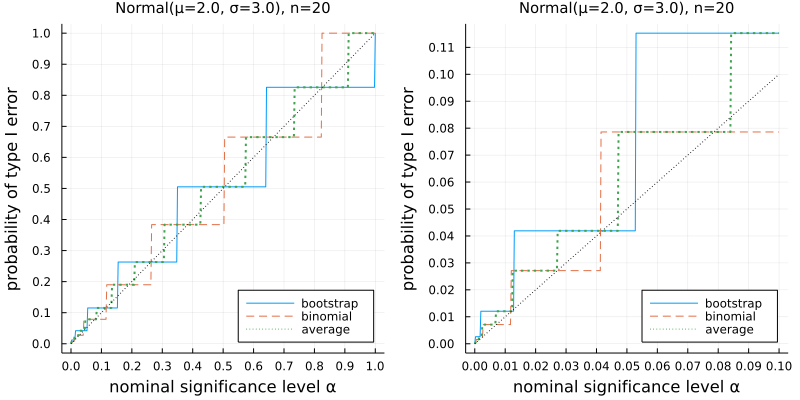

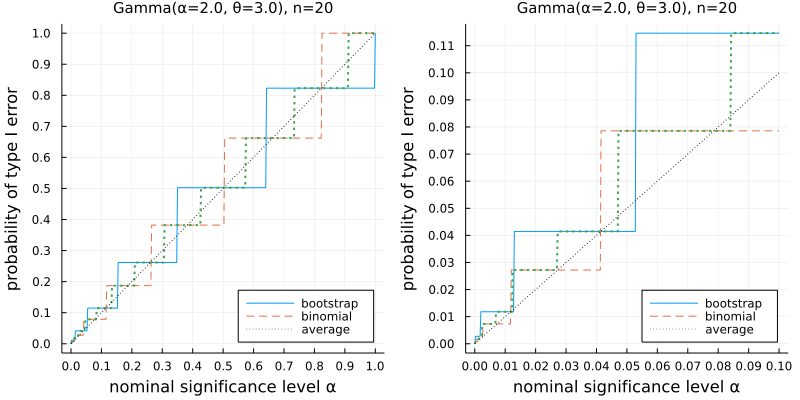

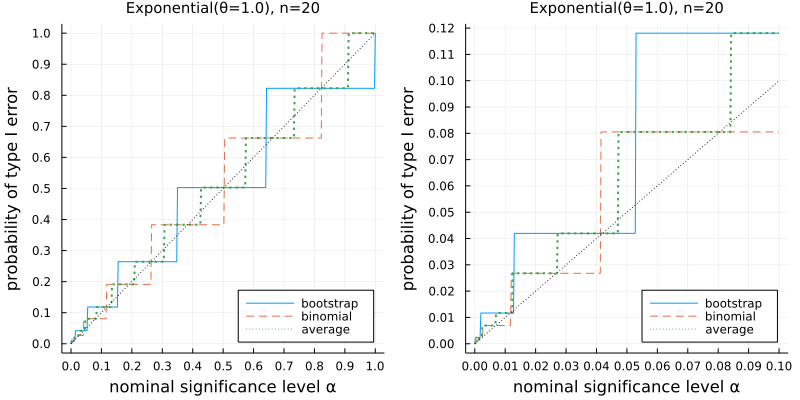

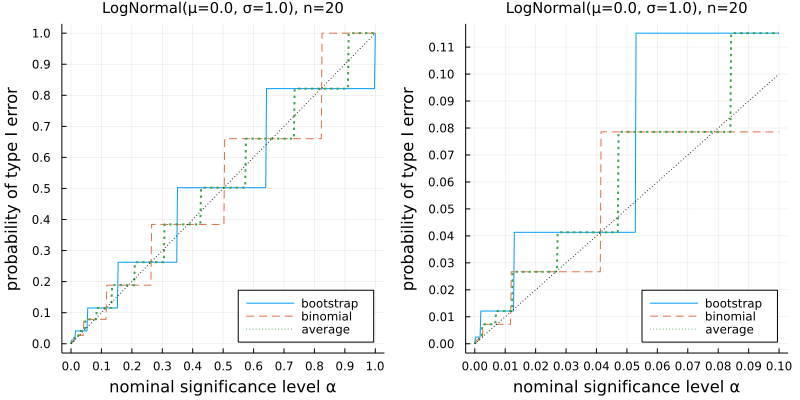

In [13]:
for dist in (Normal(2, 3), Gamma(2, 3), Exponential(), LogNormal())
    plot_probtype1error3(; dist, n = 20) |> display
    println(); flush(stdout)
end

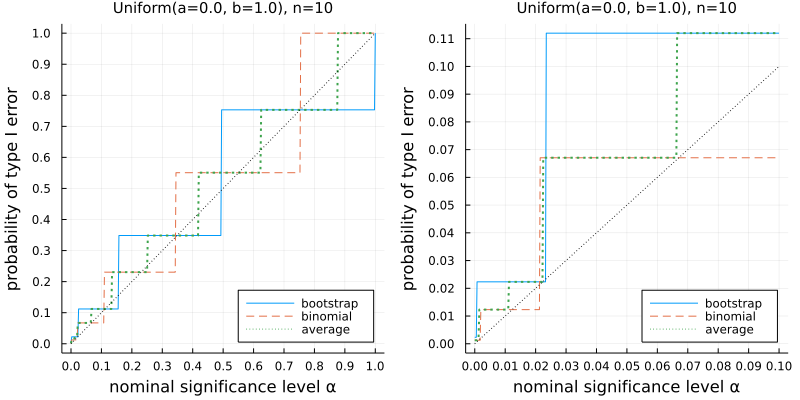

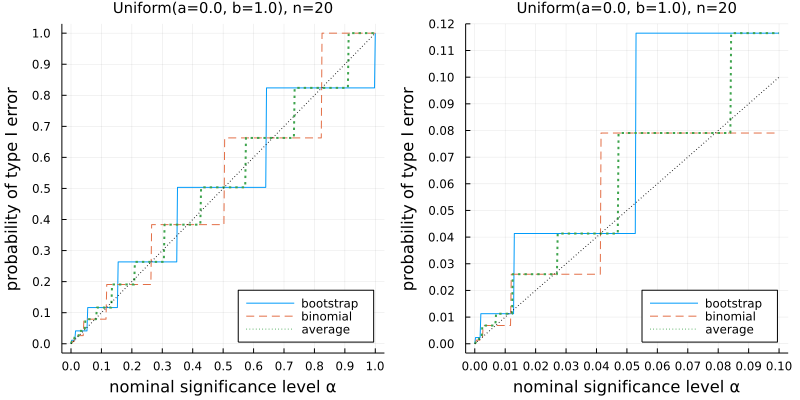

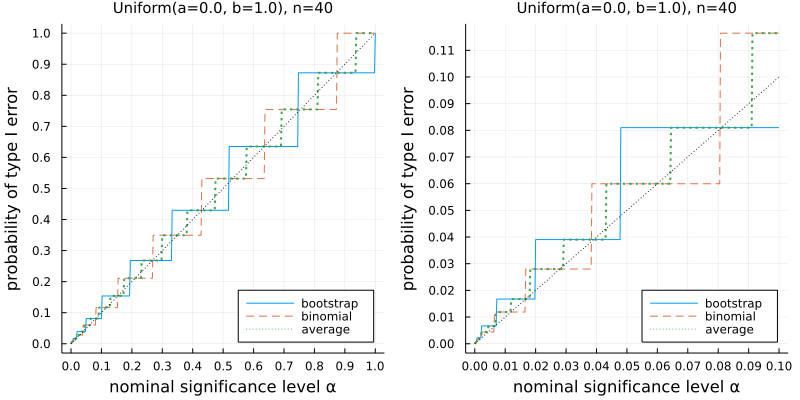

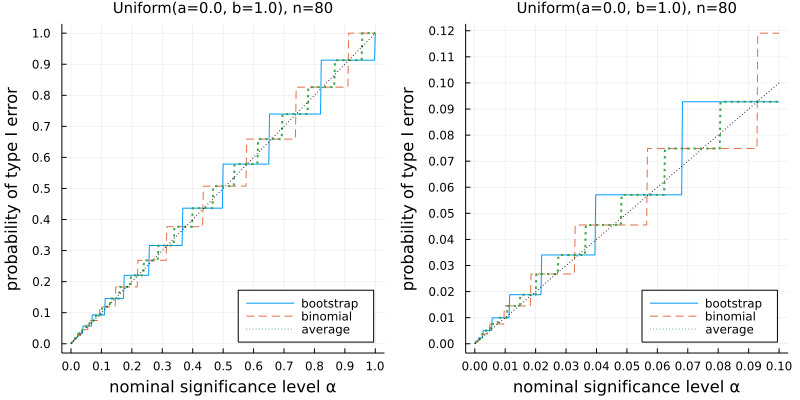

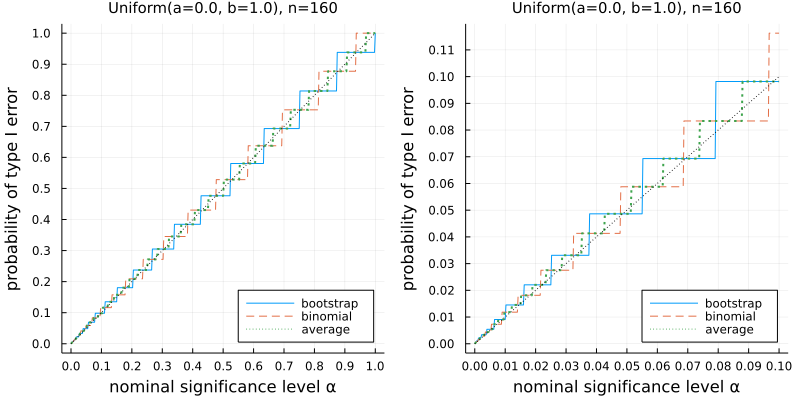

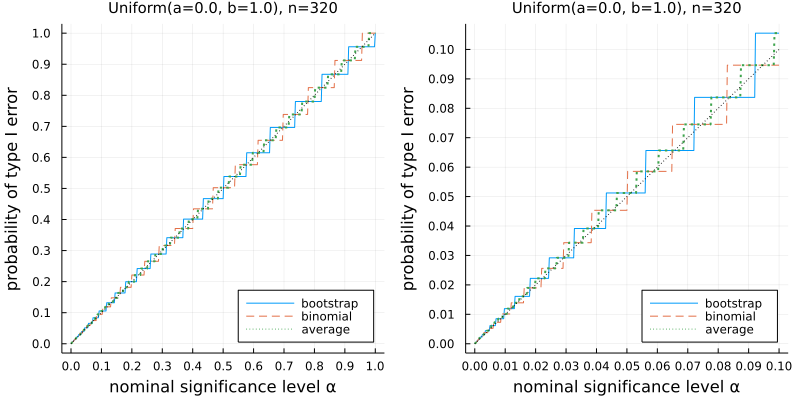

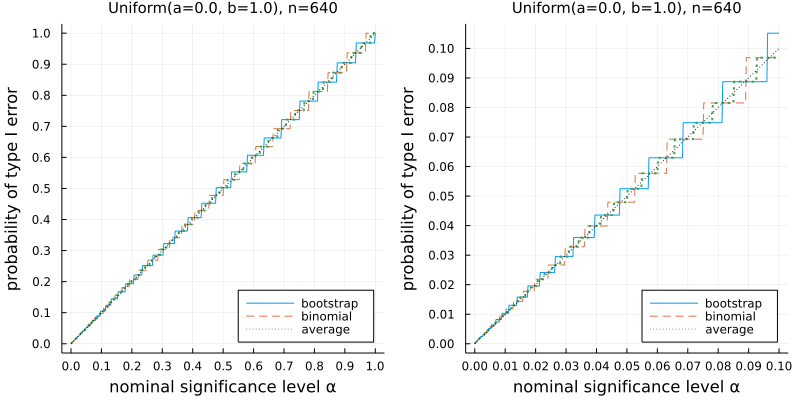

In [14]:
dist = Uniform()
for n in (10, 20, 40, 80, 160, 320, 640)
    plot_probtype1error3(; dist, n) |> display
    println(); flush(stdout)
end

## ヒストグラムの中央値の信頼区間

### ヒストグラムデータ

H = Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  -0.5:1.0:21.5
weights: [1, 5, 6, 1, 7, 6, 3, 2, 3, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
closed: left
isdensity: false


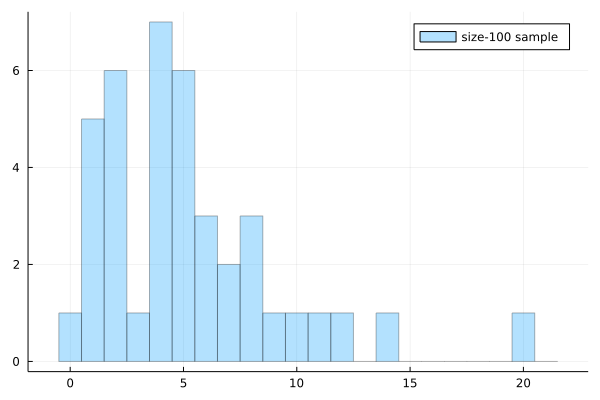

In [15]:
Random.seed!(4649373)

dist, n = Gamma(2, 3), 40
X = rand(dist, n)
bin = -0.5:21.5
H = fit(Histogram, X, bin)
@show H
plot(H; alpha=0.3, label="size-100 sample")

### ヒストグラム分布

In [16]:
function histogramdist(h::Histogram)
    e = h.edges[1]
    w = h.weights
    u = [Uniform(e[i], e[i+1]) for i in eachindex(e)[1:end-1]]
    p = w/sum(w)
    MixtureModel(u, p)
end

histogramdist (generic function with 1 method)

Hdist = MixtureModel{Uniform{Float64}}(K = 22)
components[1] (prior = 0.0250): Uniform{Float64}(a=-0.5, b=0.5)
components[2] (prior = 0.1250): Uniform{Float64}(a=0.5, b=1.5)
components[3] (prior = 0.1500): Uniform{Float64}(a=1.5, b=2.5)
components[4] (prior = 0.0250): Uniform{Float64}(a=2.5, b=3.5)
components[5] (prior = 0.1750): Uniform{Float64}(a=3.5, b=4.5)
components[6] (prior = 0.1500): Uniform{Float64}(a=4.5, b=5.5)
components[7] (prior = 0.0750): Uniform{Float64}(a=5.5, b=6.5)
components[8] (prior = 0.0500): Uniform{Float64}(a=6.5, b=7.5)
The rest are omitted ...



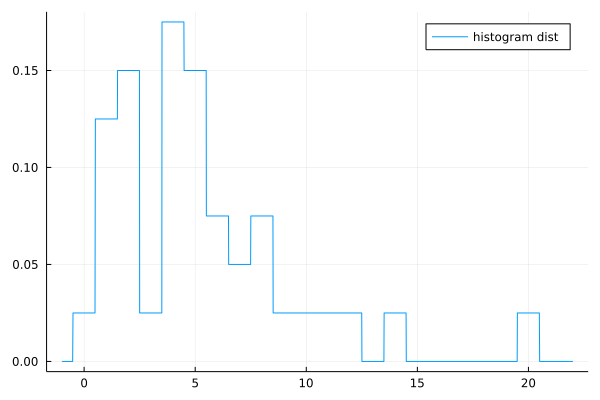

In [17]:
Hdist = histogramdist(H)
@show Hdist
plot(x -> pdf(Hdist, x), -1, 22; label="histogram dist")

### ブートストラップ法

In [18]:
function ci_median_bootstrap(H::Histogram; α = 0.05)
    Hdist = histogramdist(H)
    beta = beta_median(sum(H.weights))
    L = quantile(Hdist, quantile(beta, α/2))
    U = quantile(Hdist, quantile(beta, 1 - α/2))
    L, U
end

function cdf_median_bootstrap(H::Histogram, a)
    Hdist = histogramdist(H)
    n = sum(H.weights)
    beta = beta_median(n)
    cdf(beta, cdf(Hdist, a))
end

cdf_median_bootstrap (generic function with 2 methods)

In [19]:
ci_median_bootstrap(H)

(3.6505279646597986, 5.491050707873999)

In [20]:
pval_median_bootstrap(H, 3.8)

0.10895738291743735

### 二項分布に帰着

In [21]:
function ci_median_binomial(H::Histogram; α = 0.05)
    Hdist = histogramdist(H)
    n = sum(H.weights)
    bin = bin_median(n)
    L = quantile(Hdist, quantile(bin, α/2)/n)
    U = quantile(Hdist, quantile(bin, 1-α/2)/n)
    L, U
end

function pval_median_binomial(H::Histogram, a)
    Hdist = histogramdist(H)
    n = sum(H.weights)
    bin = bin_median(n)
    c = cdf(Hdist, a)
    k = floor(Int, n*c)
    l = ceil(Int, n*c) - 1
    min(1, 2cdf(bin, k), 2ccdf(bin, l))
end

pval_median_binomial (generic function with 2 methods)

In [22]:
ci_median_binomial(H)

(3.6428571428528818, 5.500000000016733)

In [23]:
pval_median_binomial(H, 3.8)

0.15385994416283233

### 比較

ci_bst = ci_median_bootstrap(H; α = 0.05) = (3.6505279646597986, 5.491050707873999)
ci_bin = ci_median_binomial(H; α = 0.05) = (3.6428571428528818, 5.500000000016733)


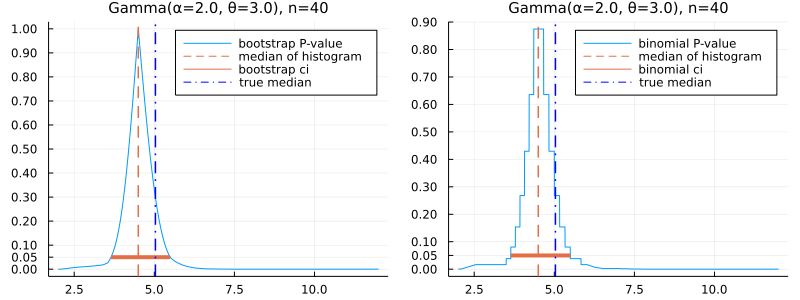

In [24]:
# 信頼区間の計算
@show ci_bst = ci_median_bootstrap(H; α = 0.05)
@show ci_bin = ci_median_binomial(H; α = 0.05)

# プロット
P2 = plot(x -> pval_median_bootstrap(H, x), 2, 12; label="bootstrap P-value")
vline!([median(Hdist)]; label="median of histogram", lw=1.5, c=2, ls=:dash)
plot!(collect(ci_bst), fill(0.05, 2); label="bootstrap ci", lw=4, c=2)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")
plot!(; ytick=[0:0.05:0.1; 0.2:0.1:1])

P3 = plot(x -> pval_median_binomial(H, x), 2, 12; label="binomial P-value")
vline!([median(Hdist)]; label="median of histogram", lw=1.5, c=2, ls=:dash)
plot!(collect(ci_bin), fill(0.05, 2); label="binomial ci", lw=4, c=2)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")
plot!(; ytick=[0:0.05:0.1; 0.2:0.1:1])

plot(P2, P3; size=(800, 300))

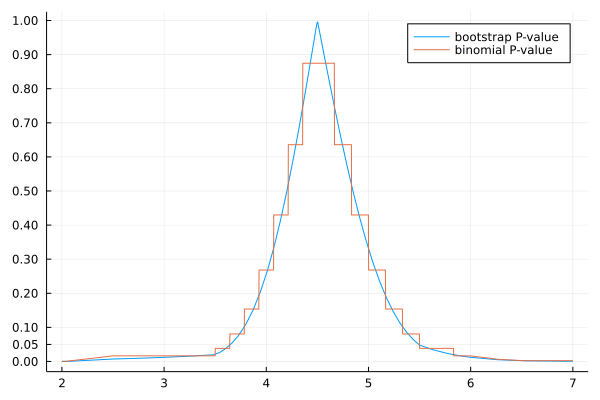

In [25]:
plot(x -> pval_median_bootstrap(H, x), 2, 7; label="bootstrap P-value")
plot!(x -> pval_median_binomial(H, x), 2, 7; label="binomial P-value")
plot!(; xtick=-1:21, ytick=[0:0.05:0.1; 0.2:0.1:1])